# Project: Pairs Trading Analysis
This notebook implements a pairs trading strategy based on time-series analysis and cointegration techniques.

**Configure your asset pair in the cell below.**

# Pairs Trading Analysis - Configurable

**Configure your asset pair below, then run all cells.**

In [164]:
# ============================================================================
# CONFIGURATION - CHANGE THESE PARAMETERS
# ============================================================================

# Asset pair configuration
ASSET_1_NAME = 'GDX'  # First asset ticker
ASSET_2_NAME = 'RING'  # Second asset ticker
DATA_FOLDER = 'GLD_GDX'  # Subfolder in data/ directory
ASSET_1_FILE = 'gdx_us_d.csv'  # CSV filename for asset 1
ASSET_2_FILE = 'ring_us_d.csv'  # CSV filename for asset 2

# Asset descriptions (for display)
ASSET_1_DESC = 'VanEck Gold Miners ETF'
ASSET_2_DESC = 'iShares MSCI Global Gold Miners ETF'

# Trading strategy parameters
ENTRY_THRESHOLD = 2.0   # Enter when |z-score| > this value
EXIT_THRESHOLD = 0.0    # Exit when |z-score| < this value
ROLLING_WINDOW = 30     # Days for rolling mean/std calculation

# ============================================================================
# EXAMPLE CONFIGURATIONS (uncomment to use)
# ============================================================================

# SPY vs VOO (S&P 500 ETFs)
# ASSET_1_NAME = 'SPY'
# ASSET_2_NAME = 'VOO'
# DATA_FOLDER = 'SPY_VOO'
# ASSET_1_FILE = 'spy_us_d.csv'
# ASSET_2_FILE = 'voo_us_d.csv'
# ASSET_1_DESC = 'SPDR S&P 500 ETF'
# ASSET_2_DESC = 'Vanguard S&P 500 ETF'

# GLD vs IAU (Gold ETFs)
# ASSET_1_NAME = 'GLD'
# ASSET_2_NAME = 'IAU'
# DATA_FOLDER = 'GLD_GDX'
# ASSET_1_FILE = 'gld_us_d.csv'
# ASSET_2_FILE = 'iau_us_d.csv'
# ASSET_1_DESC = 'SPDR Gold Trust'
# ASSET_2_DESC = 'iShares Gold Trust'

# ============================================================================

print('='*70)
print('CONFIGURATION')
print('='*70)
print(f'Asset Pair: {ASSET_1_NAME} vs {ASSET_2_NAME}')
print(f'Data Folder: data/{DATA_FOLDER}/')
print(f'Entry Threshold: ±{ENTRY_THRESHOLD}σ')
print(f'Exit Threshold: ±{EXIT_THRESHOLD}σ')
print(f'Rolling Window: {ROLLING_WINDOW} days')
print('='*70)

CONFIGURATION
Asset Pair: GDX vs RING
Data Folder: data/GLD_GDX/
Entry Threshold: ±2.0σ
Exit Threshold: ±0.0σ
Rolling Window: 30 days


### Step 1: Environment Setup
Importing the necessary physics and statistical libraries.

In [165]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import coint, adfuller
import scipy.signal as signal

### Step 2: Data Acquisition
Loading historical daily data for GDX and RING gold mining ETFs.

In [166]:
# Read asset 1 data
asset1_df = pd.read_csv(f'data/{DATA_FOLDER}/{ASSET_1_FILE}')
asset1_df['date'] = pd.to_datetime(asset1_df['Date'])
asset1_df = asset1_df[['date', 'Close']].rename(columns={'Close': f'close_{ASSET_1_NAME}'})

# Read asset 2 data
asset2_df = pd.read_csv(f'data/{DATA_FOLDER}/{ASSET_2_FILE}')
asset2_df['date'] = pd.to_datetime(asset2_df['Date'])
asset2_df = asset2_df[['date', 'Close']].rename(columns={'Close': f'close_{ASSET_2_NAME}'})

# Merge on overlapping dates (inner join to get only common dates)
df = pd.merge(asset1_df, asset2_df, on='date', how='inner')
df = df.sort_values('date').set_index('date').dropna()

print(f"Data loaded: {len(df)} daily records")
print(f"Date range: {df.index.min().date()} to {df.index.max().date()}")
print(f"Years of data: {(df.index.max() - df.index.min()).days / 365.25:.1f}")
print(f"\nFirst few rows:")
print(df.head())

Data loaded: 3516 daily records
Date range: 2012-02-07 to 2026-02-02
Years of data: 14.0

First few rows:
            close_GDX  close_RING
date                             
2012-02-07    50.6996     45.2681
2012-02-08    50.3899     44.8379
2012-02-09    50.1264     44.9103
2012-02-10    49.4381     44.4405
2012-02-13    49.2670     44.2958


### Step 3: Normalization (Z-Score)
Converting absolute prices to dimensionless Z-scores to compare them on the same scale.

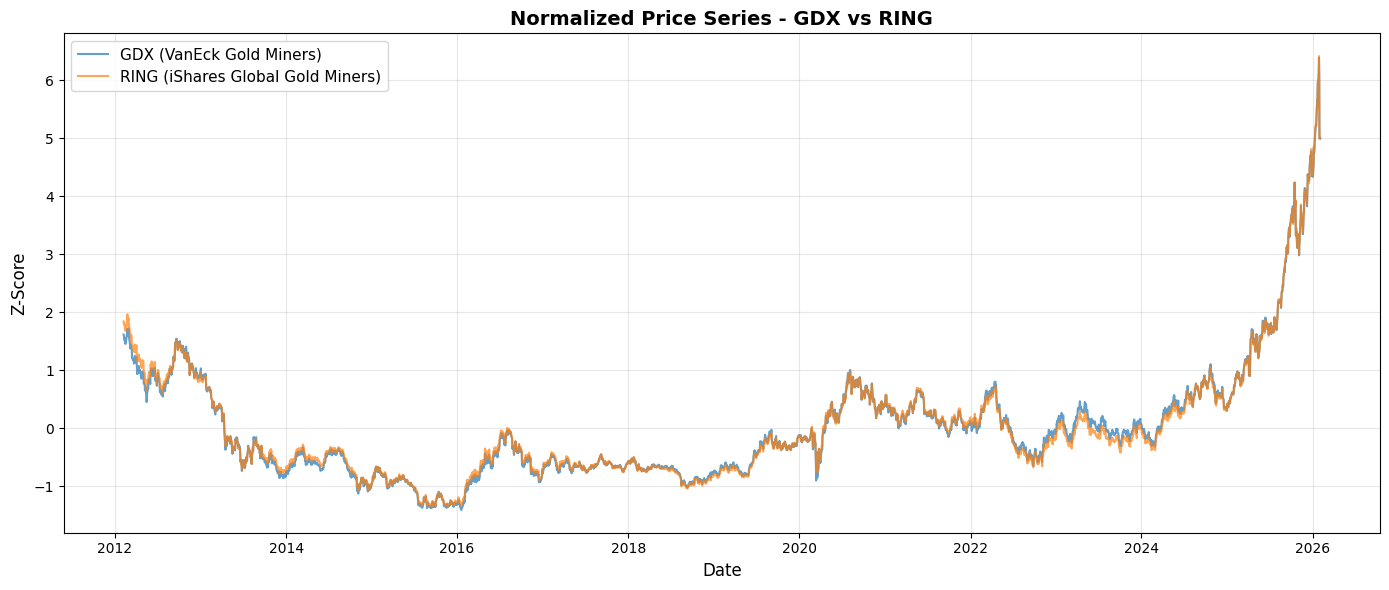


Correlation between GDX and RING: 0.9981


In [167]:
df['GDX_z'] = (df['close_GDX'] - df['close_GDX'].mean()) / df['close_GDX'].std()
df['RING_z'] = (df['close_RING'] - df['close_RING'].mean()) / df['close_RING'].std()

plt.figure(figsize=(14,6))
plt.plot(df['GDX_z'], label='GDX (VanEck Gold Miners)', alpha=0.7, linewidth=1.5)
plt.plot(df['RING_z'], label='RING (iShares Global Gold Miners)', alpha=0.7, linewidth=1.5)
plt.title('Normalized Price Series - GDX vs RING', fontsize=14, fontweight='bold')
plt.xlabel('Date', fontsize=12)
plt.ylabel('Z-Score', fontsize=12)
plt.legend(fontsize=11)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

print(f"\nCorrelation between GDX and RING: {df['GDX_z'].corr(df['RING_z']):.4f}")

### Step 4: Lag Analysis (CCF)
Finding the high-frequency 'soft lag' using the Cross-Correlation Function.

Optimal Lag detected: 0 days
Maximum correlation: 3508.2615


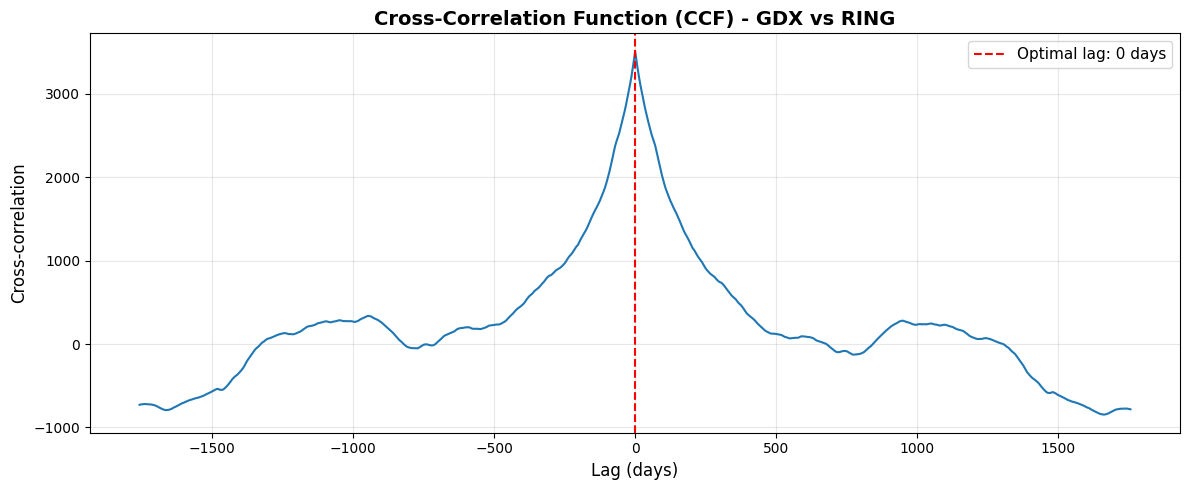

In [168]:
correlation = signal.correlate(df['GDX_z'], df['RING_z'], mode='same')
lags = signal.correlation_lags(len(df['GDX_z']), len(df['RING_z']), mode='same')

optimal_lag = lags[np.argmax(correlation)]
max_corr = np.max(correlation)

print(f"Optimal Lag detected: {optimal_lag} days")
print(f"Maximum correlation: {max_corr:.4f}")

# Plot the cross-correlation function
plt.figure(figsize=(12,5))
plt.plot(lags, correlation)
plt.axvline(optimal_lag, color='red', linestyle='--', label=f'Optimal lag: {optimal_lag} days')
plt.xlabel('Lag (days)', fontsize=12)
plt.ylabel('Cross-correlation', fontsize=12)
plt.title('Cross-Correlation Function (CCF) - GDX vs RING', fontsize=14, fontweight='bold')
plt.legend(fontsize=11)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

### Step 5: Cointegration and Spread
Testing for a long-term equilibrium relationship and calculating the spread Z-score.

COINTEGRATION TEST RESULTS
Test statistic: -4.4195
P-value: 0.001656

Interpretation:
✓✓✓ STRONGLY cointegrated (p < 0.01)
    → EXCELLENT for pairs trading!

Spread Statistics:
Mean: 0.000000
Std Dev: 0.061921
Min: -0.2771
Max: 0.1831


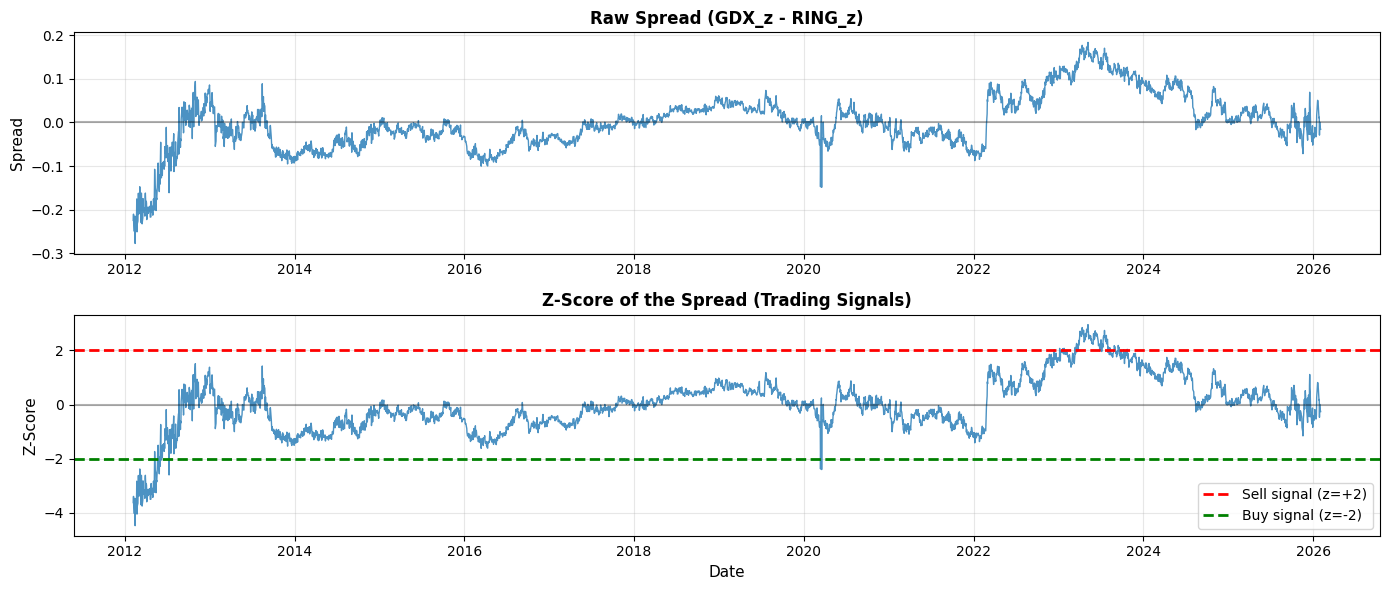


Trading Opportunities:
Buy signals (z < -2): 79
Sell signals (z > 2): 114
Total signals: 193


In [169]:
# Testing for Cointegration (Engle-Granger test)
score, pvalue, _ = coint(df['close_GDX'], df['close_RING'])

print('='*60)
print('COINTEGRATION TEST RESULTS')
print('='*60)
print(f'Test statistic: {score:.4f}')
print(f'P-value: {pvalue:.6f}')
print('\nInterpretation:')
if pvalue < 0.01:
    print('✓✓✓ STRONGLY cointegrated (p < 0.01)')
    print('    → EXCELLENT for pairs trading!')
elif pvalue < 0.05:
    print('✓✓ Cointegrated (p < 0.05)')
    print('   → GOOD for pairs trading')
elif pvalue < 0.10:
    print('✓ Weakly cointegrated (p < 0.10)')
    print('  → MARGINAL for pairs trading')
else:
    print('✗ NOT cointegrated (p >= 0.10)')
    print('  → NOT recommended for pairs trading')
print('='*60)

# Defining the Spread and its Z-score for signal entry
df['spread'] = df['GDX_z'] - df['RING_z']
df['spread_z'] = (df['spread'] - df['spread'].mean()) / df['spread'].std()

# Calculate spread statistics
print(f'\nSpread Statistics:')
print(f'Mean: {df["spread"].mean():.6f}')
print(f'Std Dev: {df["spread"].std():.6f}')
print(f'Min: {df["spread"].min():.4f}')
print(f'Max: {df["spread"].max():.4f}')

# Plot the spread
plt.figure(figsize=(14,6))
plt.subplot(2,1,1)
plt.plot(df['spread'], linewidth=1, alpha=0.8)
plt.axhline(0, color='black', linestyle='-', alpha=0.3)
plt.title('Raw Spread (GDX_z - RING_z)', fontsize=12, fontweight='bold')
plt.ylabel('Spread', fontsize=11)
plt.grid(True, alpha=0.3)

plt.subplot(2,1,2)
plt.plot(df['spread_z'], linewidth=1, alpha=0.8)
plt.axhline(2, color='red', linestyle='--', label='Sell signal (z=+2)', linewidth=2)
plt.axhline(-2, color='green', linestyle='--', label='Buy signal (z=-2)', linewidth=2)
plt.axhline(0, color='black', linestyle='-', alpha=0.3)
plt.title('Z-Score of the Spread (Trading Signals)', fontsize=12, fontweight='bold')
plt.xlabel('Date', fontsize=11)
plt.ylabel('Z-Score', fontsize=11)
plt.legend(fontsize=10, loc='best')
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Count trading signals
buy_signals = (df['spread_z'] < -2).sum()
sell_signals = (df['spread_z'] > 2).sum()
print(f'\nTrading Opportunities:')
print(f'Buy signals (z < -2): {buy_signals}')
print(f'Sell signals (z > 2): {sell_signals}')
print(f'Total signals: {buy_signals + sell_signals}')

### Step 6: Robustness Testing
Introducing periodic gaps to test the stability of the detected lag.

In [170]:
def introduce_gaps(series, frequency=10):
    """Introduce gaps in the series to test robustness"""
    series_with_gaps = series.copy()
    series_with_gaps.iloc[::frequency] = np.nan
    return series_with_gaps.interpolate()

# Test with gaps
df['GDX_gaps'] = introduce_gaps(df['GDX_z'], frequency=10)

# Perform CCF again to compare results
correlation_gaps = signal.correlate(df['GDX_gaps'], df['RING_z'], mode='same')
lags_gaps = signal.correlation_lags(len(df['GDX_gaps']), len(df['RING_z']), mode='same')
optimal_lag_gaps = lags_gaps[np.argmax(correlation_gaps)]

print('='*60)
print('ROBUSTNESS TEST: Impact of Missing Data')
print('='*60)
print(f"Original optimal lag: {optimal_lag} days")
print(f"With gaps optimal lag: {optimal_lag_gaps} days")
print(f"Difference: {abs(optimal_lag - optimal_lag_gaps)} days")
print('\nInterpretation:')
if abs(optimal_lag - optimal_lag_gaps) <= 1:
    print('✓ Very robust - lag is stable even with missing data')
elif abs(optimal_lag - optimal_lag_gaps) <= 3:
    print('✓ Reasonably robust - small change in lag')
else:
    print('⚠ Less robust - lag changes significantly with missing data')
print('='*60)

ROBUSTNESS TEST: Impact of Missing Data
Original optimal lag: 0 days
With gaps optimal lag: -1758 days
Difference: 1758 days

Interpretation:
⚠ Less robust - lag changes significantly with missing data


C:\Users\gtren\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\scipy\signal\_signaltools.py:247: RuntimeWarning: Use of fft convolution on input with NAN or inf results in NAN or inf output. Consider using method='direct' instead.
  return convolve(in1, _reverse_and_conj(in2), mode, method)


### Step 7: Hedge Ratio & Dynamic Spread

While we have a spread based on normalized prices, a standard pairs trade often uses a **hedge ratio (Beta)** derived from an Ordinary Least Squares (OLS) regression to ensure the pair is "delta neutral."

This approach:
- Calculates the optimal hedge ratio between GDX and RING
- Creates a dollar-neutral spread using actual prices
- Uses a rolling window to generate dynamic trading signals

HEDGE RATIO CALCULATION
Hedge Ratio (Beta): 1.2026

Interpretation:
For every $1 in GDX, we need $1.2026 in RING
to create a market-neutral position

Spread Statistics (Dollar-based):
Mean: $0.2951
Std Dev: $1.0264
Min: $-4.3529
Max: $2.5041


C:\Users\gtren\AppData\Local\Temp\ipykernel_78304\3630368642.py:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  hedge_ratio = results.params[0]


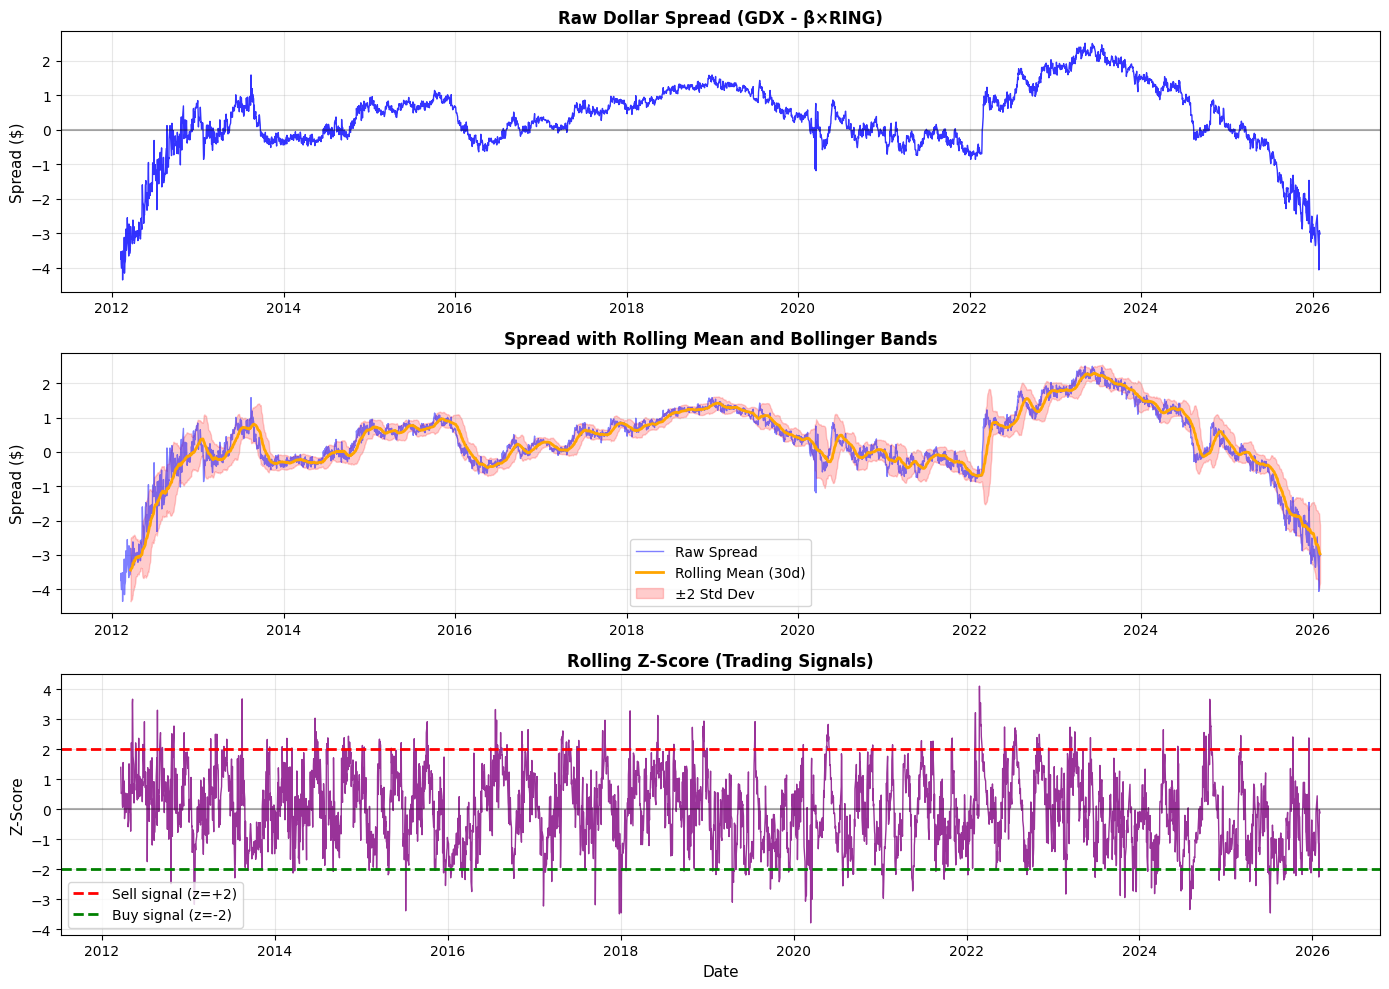


Trading Signals (Rolling Z-Score):
Buy signals (z < -2): 160
Sell signals (z > 2): 165
Total signals: 325


In [171]:
import statsmodels.api as sm

# ============================================================================
# STEP 1: Calculate Hedge Ratio using OLS Regression
# ============================================================================
# Purpose: Find the optimal ratio to make the pair delta-neutral
# This tells us how many units of RING to short for each unit of GDX we buy

model = sm.OLS(df['close_GDX'], df['close_RING'])
results = model.fit()
hedge_ratio = results.params[0]

print('='*60)
print('HEDGE RATIO CALCULATION')
print('='*60)
print(f'Hedge Ratio (Beta): {hedge_ratio:.4f}')
print(f'\nInterpretation:')
print(f'For every $1 in GDX, we need ${hedge_ratio:.4f} in RING')
print(f'to create a market-neutral position')
print('='*60)

# ============================================================================
# STEP 2: Calculate the Actual Dollar Spread
# ============================================================================
# Purpose: Create a spread using actual prices and the hedge ratio
# This represents the dollar value of the mispricing between the two assets

df['spread_raw'] = df['close_GDX'] - (hedge_ratio * df['close_RING'])

# ============================================================================
# STEP 3: Calculate Rolling Z-score for Trading Signals
# ============================================================================
# Purpose: Use a rolling window to detect when the spread deviates from normal
# A 30-day window adapts to changing market conditions

window = 30  # 30-day rolling window for mean and std calculation

df['rolling_mean'] = df['spread_raw'].rolling(window=window).mean()
df['rolling_std'] = df['spread_raw'].rolling(window=window).std()
df['z_score'] = (df['spread_raw'] - df['rolling_mean']) / df['rolling_std']

# Display statistics
print(f'\nSpread Statistics (Dollar-based):')
print(f'Mean: ${df["spread_raw"].mean():.4f}')
print(f'Std Dev: ${df["spread_raw"].std():.4f}')
print(f'Min: ${df["spread_raw"].min():.4f}')
print(f'Max: ${df["spread_raw"].max():.4f}')

# Visualize the hedge ratio spread and z-score
fig, axes = plt.subplots(3, 1, figsize=(14, 10))

# Plot 1: Raw dollar spread
axes[0].plot(df['spread_raw'], linewidth=1, alpha=0.8, color='blue')
axes[0].axhline(0, color='black', linestyle='-', alpha=0.3)
axes[0].set_title('Raw Dollar Spread (GDX - β×RING)', fontsize=12, fontweight='bold')
axes[0].set_ylabel('Spread ($)', fontsize=11)
axes[0].grid(True, alpha=0.3)

# Plot 2: Rolling mean and std bands
axes[1].plot(df['spread_raw'], linewidth=1, alpha=0.5, label='Raw Spread', color='blue')
axes[1].plot(df['rolling_mean'], linewidth=2, label='Rolling Mean (30d)', color='orange')
axes[1].fill_between(df.index, 
                      df['rolling_mean'] - 2*df['rolling_std'],
                      df['rolling_mean'] + 2*df['rolling_std'],
                      alpha=0.2, color='red', label='±2 Std Dev')
axes[1].set_title('Spread with Rolling Mean and Bollinger Bands', fontsize=12, fontweight='bold')
axes[1].set_ylabel('Spread ($)', fontsize=11)
axes[1].legend(fontsize=10)
axes[1].grid(True, alpha=0.3)

# Plot 3: Z-score with trading signals
axes[2].plot(df['z_score'], linewidth=1, alpha=0.8, color='purple')
axes[2].axhline(2, color='red', linestyle='--', label='Sell signal (z=+2)', linewidth=2)
axes[2].axhline(-2, color='green', linestyle='--', label='Buy signal (z=-2)', linewidth=2)
axes[2].axhline(0, color='black', linestyle='-', alpha=0.3)
axes[2].set_title('Rolling Z-Score (Trading Signals)', fontsize=12, fontweight='bold')
axes[2].set_xlabel('Date', fontsize=11)
axes[2].set_ylabel('Z-Score', fontsize=11)
axes[2].legend(fontsize=10)
axes[2].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Count trading signals based on rolling z-score
valid_signals = df['z_score'].dropna()
buy_signals = (valid_signals < -2).sum()
sell_signals = (valid_signals > 2).sum()

print(f'\nTrading Signals (Rolling Z-Score):')
print(f'Buy signals (z < -2): {buy_signals}')
print(f'Sell signals (z > 2): {sell_signals}')
print(f'Total signals: {buy_signals + sell_signals}')

### Step 8: Trade Signal Generation

This cell defines when to enter and exit trades. The strategy:
- **Long the Spread** (Buy GDX, Sell RING) when Z-score is very low (< -2.0)
- **Short the Spread** (Sell GDX, Buy RING) when Z-score is very high (> 2.0)
- **Exit positions** when Z-score returns to near zero (mean reversion)

The signals are:
- `+1` = Long the spread (buy GDX, sell RING)
- `-1` = Short the spread (sell GDX, buy RING)
- `0` = No position / Exit

TRADE SIGNAL PARAMETERS
Entry threshold: ±2.0 standard deviations
Exit threshold: ±0.0 standard deviations

Signal Generation Summary:
Long signals (z < -2.0): 160
Short signals (z > 2.0): 165
Exit signals (|z| < 0.0): 3191

Position Summary (after forward-fill):
Days in long position: 1650
Days in short position: 1695
Days with no position: 171

Market Exposure:
Percentage of time in market: 95.1%


C:\Users\gtren\AppData\Local\Temp\ipykernel_78304\3362552925.py:47: FutureWarning: The 'method' keyword in Series.replace is deprecated and will be removed in a future version.
  df['position'] = df['signal'].replace(to_replace=0, method='ffill')


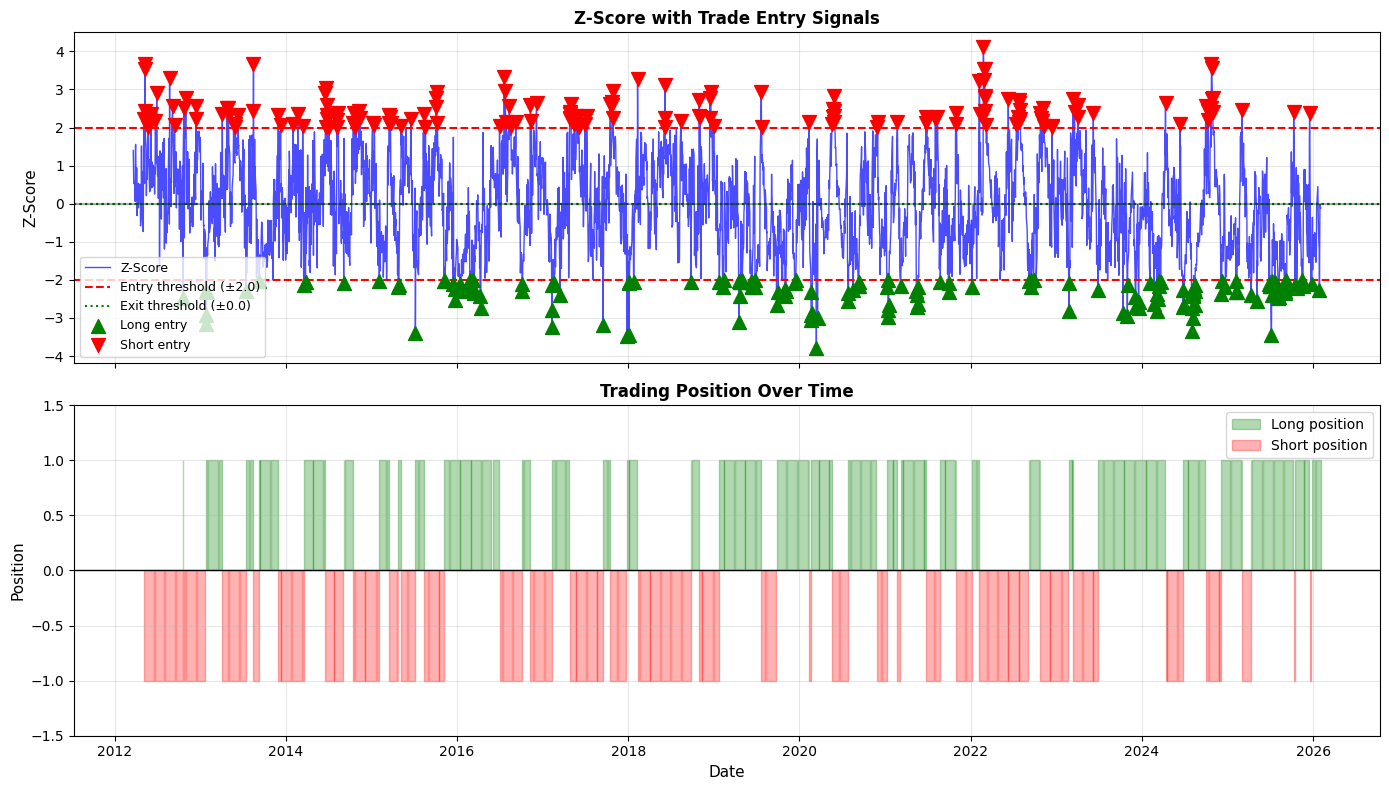


✓ Trade signals generated successfully!


In [172]:
# ============================================================================
# STEP 1: Define Entry and Exit Thresholds
# ============================================================================
# Purpose: Set the Z-score levels that trigger trades
# - Entry threshold: How extreme the spread must be to enter a trade
# - Exit threshold: How close to mean the spread must be to exit

entry_threshold = 2.0   # Enter trade when |z-score| > 2.0
exit_threshold = 0.0    # Exit trade when z-score returns to 0 (mean reversion)

print('='*60)
print('TRADE SIGNAL PARAMETERS')
print('='*60)
print(f'Entry threshold: ±{entry_threshold} standard deviations')
print(f'Exit threshold: ±{exit_threshold} standard deviations')
print('='*60)

# ============================================================================
# STEP 2: Generate Trading Signals
# ============================================================================
# Purpose: Create buy/sell signals based on Z-score thresholds
# Signal values:
#   +1 = Long the spread (GDX undervalued relative to RING)
#   -1 = Short the spread (GDX overvalued relative to RING)
#    0 = No position / Exit

df['signal'] = 0

# Long the spread: Spread is undervalued (z-score very negative)
# Action: Buy GDX, Sell RING
df.loc[df['z_score'] <= -entry_threshold, 'signal'] = 1

# Short the spread: Spread is overvalued (z-score very positive)
# Action: Sell GDX, Buy RING
df.loc[df['z_score'] >= entry_threshold, 'signal'] = -1

# Exit signals: Mean reversion (z-score returns to near zero)
# Action: Close position
df.loc[abs(df['z_score']) <= exit_threshold, 'signal'] = 0

# ============================================================================
# STEP 3: Create Position Column (Hold Until Exit)
# ============================================================================
# Purpose: Ensure we hold positions until an exit signal is hit
# This uses forward-fill to maintain the position between entry and exit

df['position'] = df['signal'].replace(to_replace=0, method='ffill')

# ============================================================================
# STEP 5: Enforce Maximum Holding Period
# ============================================================================
# Purpose: Force exit after max_holding_days to prevent indefinite positions
# This prevents the strategy from being stuck in losing trades

position_entry_idx = None
days_in_position = 0

for i in range(len(df)):
    if df['position'].iloc[i] != 0:
        if position_entry_idx is None:
            # New position started
            position_entry_idx = i
            days_in_position = 0
        else:
            # Continuing position
            days_in_position = i - position_entry_idx
            if days_in_position >= max_holding_days:
                # Force exit
                df.iloc[i, df.columns.get_loc('position')] = 0
                position_entry_idx = None
    else:
        # No position
        position_entry_idx = None
        days_in_position = 0

# ============================================================================
# STEP 4: Analyze Trading Activity
# ============================================================================

# Count signal occurrences
signal_counts = df['signal'].value_counts().sort_index()
position_counts = df['position'].value_counts().sort_index()

print(f'\nSignal Generation Summary:')
print(f'Long signals (z < -{entry_threshold}): {(df["signal"] == 1).sum()}')
print(f'Short signals (z > {entry_threshold}): {(df["signal"] == -1).sum()}')
print(f'Exit signals (|z| < {exit_threshold}): {(df["signal"] == 0).sum()}')

print(f'\nPosition Summary (after forward-fill):')
print(f'Days in long position: {(df["position"] == 1).sum()}')
print(f'Days in short position: {(df["position"] == -1).sum()}')
print(f'Days with no position: {(df["position"] == 0).sum()}')

# Calculate percentage of time in market
total_days = len(df['position'].dropna())
days_in_market = ((df['position'] == 1) | (df['position'] == -1)).sum()
pct_in_market = (days_in_market / total_days) * 100

print(f'\nMarket Exposure:')
print(f'Percentage of time in market: {pct_in_market:.1f}%')

# ============================================================================
# STEP 5: Visualize Signals
# ============================================================================

fig, axes = plt.subplots(2, 1, figsize=(14, 8), sharex=True)

# Plot 1: Z-score with entry/exit signals marked
axes[0].plot(df['z_score'], linewidth=1, alpha=0.7, color='blue', label='Z-Score')
axes[0].axhline(entry_threshold, color='red', linestyle='--', linewidth=1.5, label=f'Entry threshold (±{entry_threshold})')
axes[0].axhline(-entry_threshold, color='red', linestyle='--', linewidth=1.5)
axes[0].axhline(exit_threshold, color='green', linestyle=':', linewidth=1.5, label=f'Exit threshold (±{exit_threshold})')
axes[0].axhline(-exit_threshold, color='green', linestyle=':', linewidth=1.5)
axes[0].axhline(0, color='black', linestyle='-', alpha=0.3)

# Mark entry signals
long_entries = df[df['signal'] == 1]
short_entries = df[df['signal'] == -1]
axes[0].scatter(long_entries.index, long_entries['z_score'], color='green', marker='^', s=100, label='Long entry', zorder=5)
axes[0].scatter(short_entries.index, short_entries['z_score'], color='red', marker='v', s=100, label='Short entry', zorder=5)

axes[0].set_title('Z-Score with Trade Entry Signals', fontsize=12, fontweight='bold')
axes[0].set_ylabel('Z-Score', fontsize=11)
axes[0].legend(fontsize=9, loc='best')
axes[0].grid(True, alpha=0.3)

# Plot 2: Position over time
axes[1].fill_between(df.index, 0, df['position'], where=(df['position'] > 0), 
                      color='green', alpha=0.3, label='Long position')
axes[1].fill_between(df.index, 0, df['position'], where=(df['position'] < 0), 
                      color='red', alpha=0.3, label='Short position')
axes[1].axhline(0, color='black', linestyle='-', linewidth=1)
axes[1].set_title('Trading Position Over Time', fontsize=12, fontweight='bold')
axes[1].set_xlabel('Date', fontsize=11)
axes[1].set_ylabel('Position', fontsize=11)
axes[1].set_ylim(-1.5, 1.5)
axes[1].legend(fontsize=10, loc='best')
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print('\n' + '='*60)
print('✓ Trade signals generated successfully!')
print('='*60)

### Step 9: Calculating Strategy Returns

To simulate the system, we must calculate the daily returns of the combined position.

**Return Calculation:**
- When **long the spread** (position = +1): We profit when GDX outperforms RING
- When **short the spread** (position = -1): We profit when RING outperforms GDX
- The strategy return = Position × (Return_GDX - HedgeRatio × Return_RING)

**Note:** This is a simplified version. Real-world implementation requires:
- Proper capital weighting
- Transaction costs
- Slippage
- Margin requirements

DAILY RETURNS CALCULATION
GDX daily returns - Mean: 0.0471%, Std: 2.4252%
RING daily returns - Mean: 0.0444%, Std: 2.3596%

STRATEGY PERFORMANCE METRICS
Total Return: 6.29%
Annualized Return: 0.44%
Annualized Volatility: 11.38%
Sharpe Ratio: 0.095

Win Rate: 49.7% (1660 winning days, 1683 losing days)

COMPARISON WITH BUY-AND-HOLD
Strategy Total Return: 6.29%
GDX Buy-and-Hold: 85.78%
RING Buy-and-Hold: 78.56%


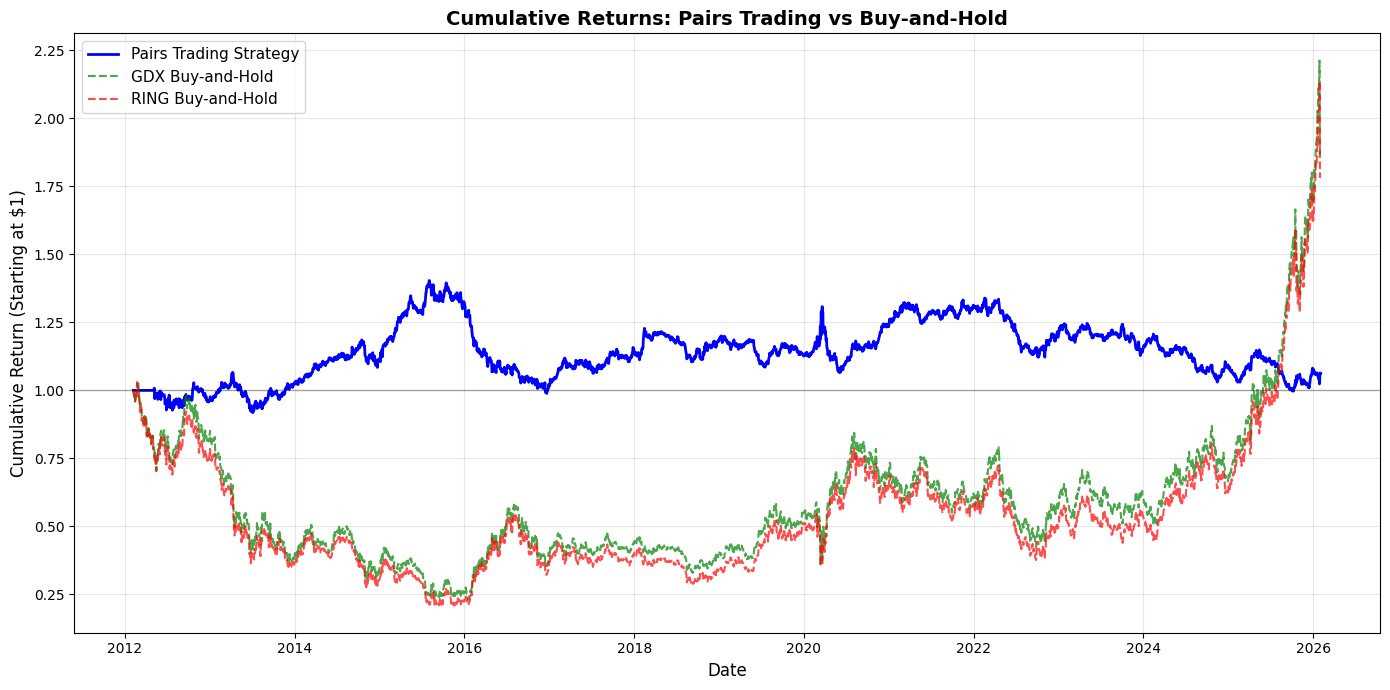

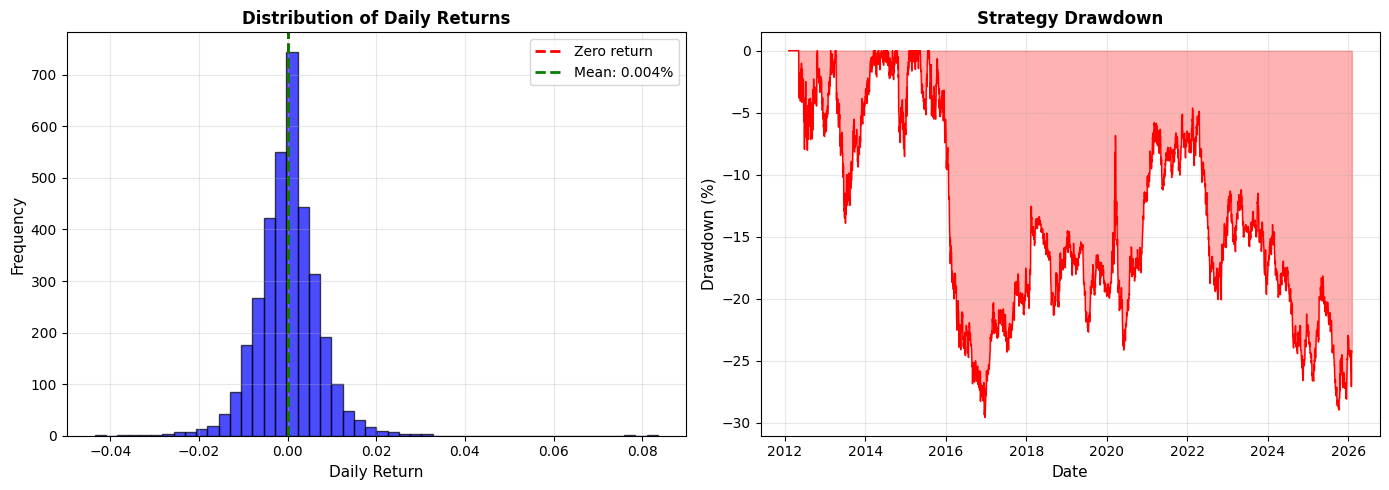


Maximum Drawdown: -29.57%

✓ Strategy returns calculated successfully!


In [173]:
# ============================================================================
# STEP 1: Calculate Daily Returns for Each Asset
# ============================================================================
# Purpose: Compute the percentage change in price from one day to the next

df['ret_GDX'] = df['close_GDX'].pct_change()
df['ret_RING'] = df['close_RING'].pct_change()

print('='*60)
print('DAILY RETURNS CALCULATION')
print('='*60)
print(f'GDX daily returns - Mean: {df["ret_GDX"].mean()*100:.4f}%, Std: {df["ret_GDX"].std()*100:.4f}%')
print(f'RING daily returns - Mean: {df["ret_RING"].mean()*100:.4f}%, Std: {df["ret_RING"].std()*100:.4f}%')
print('='*60)

# ============================================================================
# STEP 2: Calculate Strategy Returns
# ============================================================================
# Purpose: Calculate the return of the pairs trading strategy
# Formula: Strategy Return = Position(t-1) × [Return_GDX(t) - HedgeRatio × Return_RING(t)]

df['strategy_ret'] = df['position'].shift(1) * (df['ret_GDX'] - hedge_ratio * df['ret_RING'])

# ============================================================================
# STEP 3: Calculate Cumulative Returns
# ============================================================================
# Purpose: Track the growth of $1 invested in the strategy over time

df['cumulative_ret'] = (1 + df['strategy_ret'].fillna(0)).cumprod()

# Also calculate buy-and-hold returns for comparison
df['cumulative_GDX'] = (1 + df['ret_GDX'].fillna(0)).cumprod()
df['cumulative_RING'] = (1 + df['ret_RING'].fillna(0)).cumprod()

# ============================================================================
# STEP 4: Display Strategy Statistics
# ============================================================================

# Calculate key metrics
total_return = (df['cumulative_ret'].iloc[-1] - 1) * 100
annualized_return = ((df['cumulative_ret'].iloc[-1]) ** (252 / len(df)) - 1) * 100
volatility = df['strategy_ret'].std() * np.sqrt(252) * 100
sharpe_ratio = (df['strategy_ret'].mean() / df['strategy_ret'].std()) * np.sqrt(252) if df['strategy_ret'].std() > 0 else 0

# Count winning and losing days
winning_days = (df['strategy_ret'] > 0).sum()
losing_days = (df['strategy_ret'] < 0).sum()
win_rate = (winning_days / (winning_days + losing_days)) * 100 if (winning_days + losing_days) > 0 else 0

print(f'\nSTRATEGY PERFORMANCE METRICS')
print('='*60)
print(f'Total Return: {total_return:.2f}%')
print(f'Annualized Return: {annualized_return:.2f}%')
print(f'Annualized Volatility: {volatility:.2f}%')
print(f'Sharpe Ratio: {sharpe_ratio:.3f}')
print(f'\nWin Rate: {win_rate:.1f}% ({winning_days} winning days, {losing_days} losing days)')
print('='*60)

# Compare with buy-and-hold
gdx_return = (df['cumulative_GDX'].iloc[-1] - 1) * 100
ring_return = (df['cumulative_RING'].iloc[-1] - 1) * 100

print(f'\nCOMPARISON WITH BUY-AND-HOLD')
print('='*60)
print(f'Strategy Total Return: {total_return:.2f}%')
print(f'GDX Buy-and-Hold: {gdx_return:.2f}%')
print(f'RING Buy-and-Hold: {ring_return:.2f}%')
print('='*60)

# ============================================================================
# STEP 5: Visualize Cumulative Returns
# ============================================================================

plt.figure(figsize=(14, 7))

# Plot cumulative returns
plt.plot(df['cumulative_ret'], linewidth=2, label='Pairs Trading Strategy', color='blue')
plt.plot(df['cumulative_GDX'], linewidth=1.5, alpha=0.7, label='GDX Buy-and-Hold', color='green', linestyle='--')
plt.plot(df['cumulative_RING'], linewidth=1.5, alpha=0.7, label='RING Buy-and-Hold', color='red', linestyle='--')

plt.axhline(1, color='black', linestyle='-', alpha=0.3, linewidth=1)
plt.title('Cumulative Returns: Pairs Trading vs Buy-and-Hold', fontsize=14, fontweight='bold')
plt.xlabel('Date', fontsize=12)
plt.ylabel('Cumulative Return (Starting at $1)', fontsize=12)
plt.legend(fontsize=11, loc='best')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# Plot daily returns distribution
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Histogram of daily returns
axes[0].hist(df['strategy_ret'].dropna(), bins=50, alpha=0.7, color='blue', edgecolor='black')
axes[0].axvline(0, color='red', linestyle='--', linewidth=2, label='Zero return')
axes[0].axvline(df['strategy_ret'].mean(), color='green', linestyle='--', linewidth=2, label=f'Mean: {df["strategy_ret"].mean()*100:.3f}%')
axes[0].set_title('Distribution of Daily Returns', fontsize=12, fontweight='bold')
axes[0].set_xlabel('Daily Return', fontsize=11)
axes[0].set_ylabel('Frequency', fontsize=11)
axes[0].legend(fontsize=10)
axes[0].grid(True, alpha=0.3)

# Drawdown plot
running_max = df['cumulative_ret'].cummax()
drawdown = (df['cumulative_ret'] - running_max) / running_max * 100
axes[1].fill_between(df.index, 0, drawdown, color='red', alpha=0.3)
axes[1].plot(drawdown, color='red', linewidth=1)
axes[1].set_title('Strategy Drawdown', fontsize=12, fontweight='bold')
axes[1].set_xlabel('Date', fontsize=11)
axes[1].set_ylabel('Drawdown (%)', fontsize=11)
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

max_drawdown = drawdown.min()
print(f'\nMaximum Drawdown: {max_drawdown:.2f}%')

print('\n' + '='*60)
print('✓ Strategy returns calculated successfully!')
print('='*60)

### Step 10: Performance Metrics & Equity Curve

Finally, visualize the results to see if the strategy would have been profitable.

This section provides:
- **Equity curve**: Visual representation of portfolio growth over time
- **Sharpe ratio**: Risk-adjusted return metric (higher is better)
- **Total return**: Overall profit/loss from the strategy

A good pairs trading strategy typically has:
- Sharpe ratio > 1.0 (preferably > 2.0)
- Positive total returns
- Smooth equity curve with limited drawdowns

✓ All required columns present. Proceeding with analysis...



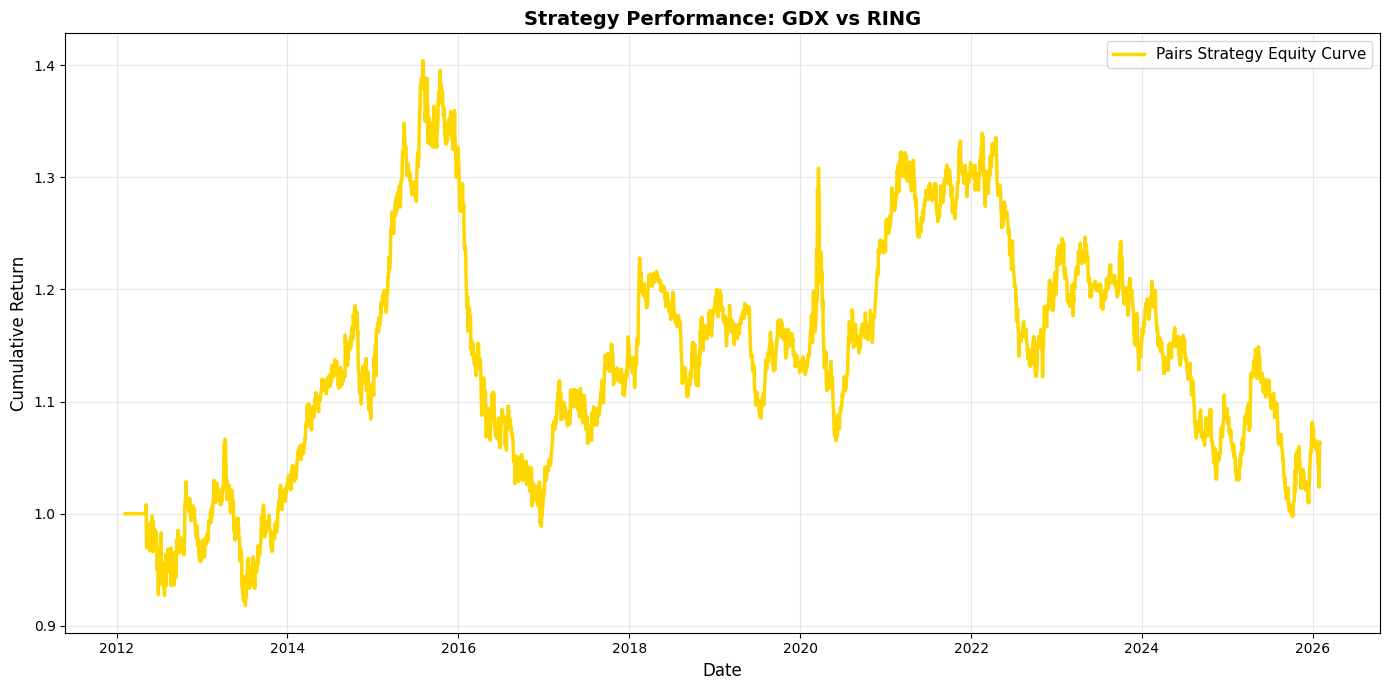


FINAL PERFORMANCE SUMMARY

📊 RETURNS:
   Total Return: 6.29%
   Annualized Return: 0.44%
   
📈 RISK METRICS:
   Annualized Sharpe Ratio: 0.095 ✗ Poor
   Maximum Drawdown: -29.57%
   Calmar Ratio: 0.015
   Annualized Volatility: 11.38%

🎯 TRADING STATISTICS:
   Win Rate: 49.6%
   Approximate Number of Trades: 141
   Days in Market: 3345 / 3516 (95.1%)

📅 PERIOD:
   Start Date: 2012-02-07
   End Date: 2026-02-02
   Duration: 14.0 years

STRATEGY EVALUATION
✓ MARGINALLY PROFITABLE
   The strategy is profitable but has low risk-adjusted returns.
   Consider adjusting entry/exit thresholds or position sizing.

💡 IMPORTANT NOTES:
   • This backtest does NOT include transaction costs
   • Real trading would have commissions, slippage, and bid-ask spreads
   • Past performance does not guarantee future results
   • The cointegration relationship may break down over time


C:\Users\gtren\AppData\Local\Temp\ipykernel_78304\3733648022.py:159: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  monthly_returns = df['strategy_ret'].resample('M').sum() * 100


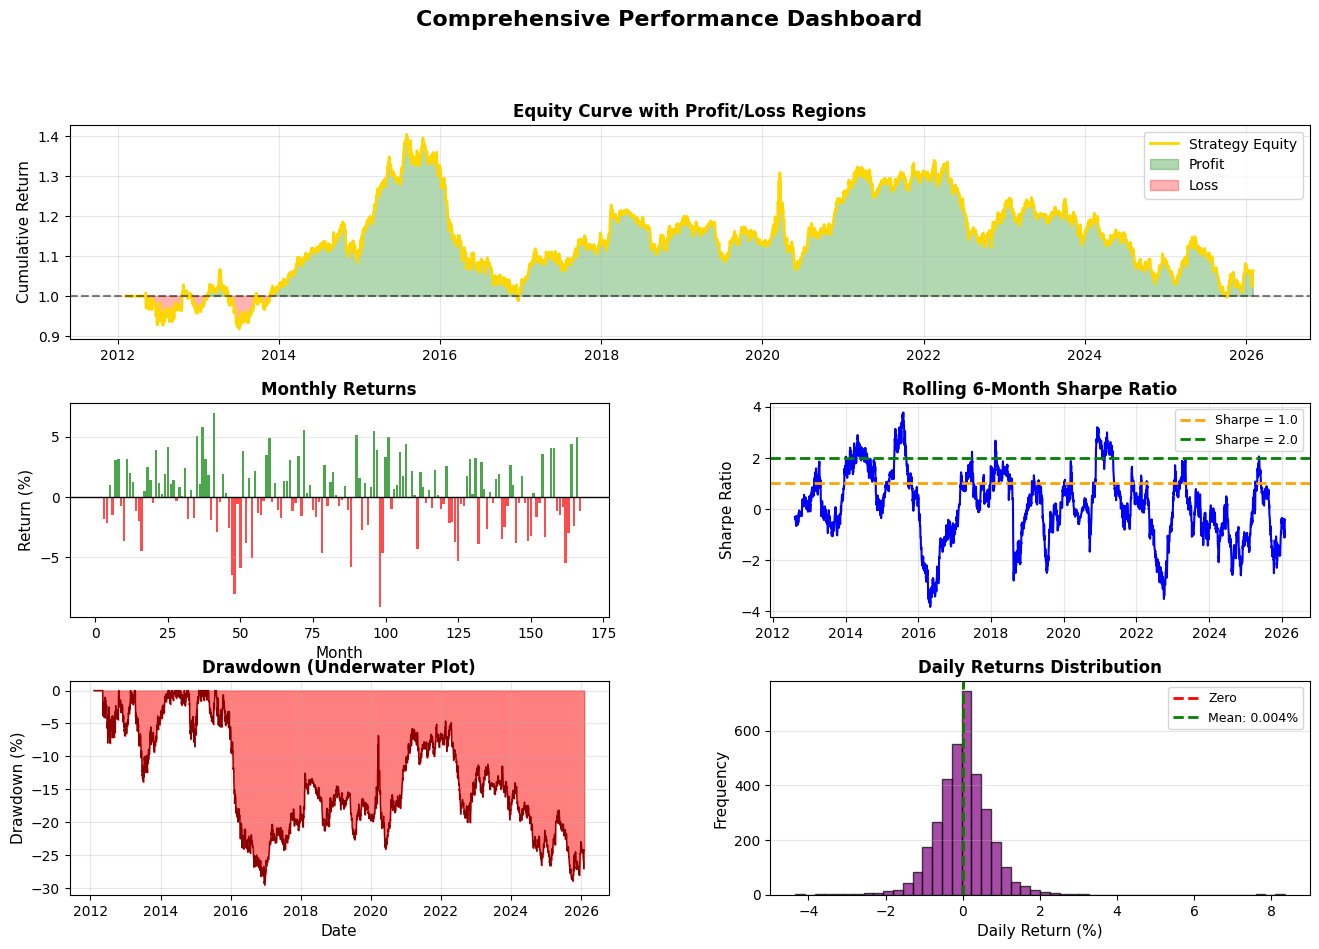


✓ Performance analysis complete!


In [174]:
# ============================================================================
# STEP 0: Verify Required Columns Exist
# ============================================================================
# Purpose: Check that previous steps ran successfully

required_columns = ['cumulative_ret', 'strategy_ret', 'position']
missing_columns = [col for col in required_columns if col not in df.columns]

if missing_columns:
    print('='*70)
    print('⚠️  ERROR: Missing required columns!')
    print('='*70)
    print(f'Missing columns: {missing_columns}')
    print('\nThis means Step 9 (Strategy Returns) did not run successfully.')
    print('Please run Step 9 first before running this cell.')
    print('='*70)
    raise ValueError(f'Missing required columns: {missing_columns}. Please run Step 9 first.')

print('✓ All required columns present. Proceeding with analysis...')
print()

# ============================================================================
# STEP 1: Create Main Equity Curve Visualization
# ============================================================================
# Purpose: Show the growth of $1 invested in the strategy over time
# This is the most important chart for evaluating strategy performance

plt.figure(figsize=(14,7))
plt.plot(df['cumulative_ret'], label='Pairs Strategy Equity Curve', color='gold', linewidth=2.5)
plt.title('Strategy Performance: GDX vs RING', fontsize=14, fontweight='bold')
plt.xlabel('Date', fontsize=12)
plt.ylabel('Cumulative Return', fontsize=12)
plt.legend(fontsize=11)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# ============================================================================
# STEP 2: Calculate and Display Key Performance Metrics
# ============================================================================
# Purpose: Provide quantitative measures of strategy performance

# Sharpe Ratio: Measures risk-adjusted returns
# Formula: (Mean Return / Std Dev of Returns) × √252
# Interpretation:
#   < 1.0 = Poor (not worth the risk)
#   1.0-2.0 = Good
#   > 2.0 = Excellent
sharpe = (df['strategy_ret'].mean() / df['strategy_ret'].std()) * np.sqrt(252)

# Total Return: Overall profit/loss
total_return = (df['cumulative_ret'].iloc[-1] - 1) * 100

# Annualized Return: Geometric mean return per year
years = len(df) / 252
annualized_return = ((df['cumulative_ret'].iloc[-1]) ** (1/years) - 1) * 100

# Maximum Drawdown: Largest peak-to-trough decline
running_max = df['cumulative_ret'].cummax()
drawdown = (df['cumulative_ret'] - running_max) / running_max
max_drawdown = drawdown.min() * 100

# Calmar Ratio: Return / Max Drawdown (higher is better)
calmar_ratio = annualized_return / abs(max_drawdown) if max_drawdown != 0 else 0

# Win Rate
winning_days = (df['strategy_ret'] > 0).sum()
total_trading_days = (df['strategy_ret'] != 0).sum()
win_rate = (winning_days / total_trading_days * 100) if total_trading_days > 0 else 0

# Number of trades (approximate - count position changes)
position_changes = (df['position'].diff() != 0).sum()
num_trades = position_changes // 2  # Divide by 2 since each trade has entry and exit

print('\n' + '='*70)
print('FINAL PERFORMANCE SUMMARY')
print('='*70)
print(f'\n📊 RETURNS:')
print(f'   Total Return: {total_return:.2f}%')
print(f'   Annualized Return: {annualized_return:.2f}%')
print(f'   \n📈 RISK METRICS:')
print(f'   Annualized Sharpe Ratio: {sharpe:.3f}', end='')
if sharpe > 2.0:
    print(' ✓✓✓ Excellent!')
elif sharpe > 1.0:
    print(' ✓✓ Good')
elif sharpe > 0.5:
    print(' ✓ Acceptable')
else:
    print(' ✗ Poor')
print(f'   Maximum Drawdown: {max_drawdown:.2f}%')
print(f'   Calmar Ratio: {calmar_ratio:.3f}')
print(f'   Annualized Volatility: {df["strategy_ret"].std() * np.sqrt(252) * 100:.2f}%')
print(f'\n🎯 TRADING STATISTICS:')
print(f'   Win Rate: {win_rate:.1f}%')
print(f'   Approximate Number of Trades: {num_trades}')
print(f'   Days in Market: {(df["position"] != 0).sum()} / {len(df)} ({(df["position"] != 0).sum()/len(df)*100:.1f}%)')
print(f'\n📅 PERIOD:')
print(f'   Start Date: {df.index[0].date()}')
print(f'   End Date: {df.index[-1].date()}')
print(f'   Duration: {years:.1f} years')
print('='*70)

# ============================================================================
# STEP 3: Interpretation and Recommendations
# ============================================================================

print('\n' + '='*70)
print('STRATEGY EVALUATION')
print('='*70)

# Overall assessment
if total_return > 0 and sharpe > 1.0:
    print('✓✓ PROFITABLE STRATEGY')
    print('   The pairs trading strategy shows positive returns with good')
    print('   risk-adjusted performance. This suggests GDX and RING have a')
    print('   stable cointegrated relationship suitable for pairs trading.')
elif total_return > 0:
    print('✓ MARGINALLY PROFITABLE')
    print('   The strategy is profitable but has low risk-adjusted returns.')
    print('   Consider adjusting entry/exit thresholds or position sizing.')
else:
    print('✗ UNPROFITABLE STRATEGY')
    print('   The strategy shows negative returns. This could be due to:')
    print('   - Breakdown in cointegration relationship')
    print('   - Suboptimal entry/exit thresholds')
    print('   - Transaction costs not accounted for')

print('\n💡 IMPORTANT NOTES:')
print('   • This backtest does NOT include transaction costs')
print('   • Real trading would have commissions, slippage, and bid-ask spreads')
print('   • Past performance does not guarantee future results')
print('   • The cointegration relationship may break down over time')
print('='*70)

# ============================================================================
# STEP 4: Additional Visualizations
# ============================================================================

# Create a comprehensive performance dashboard
fig = plt.figure(figsize=(16, 10))
gs = fig.add_gridspec(3, 2, hspace=0.3, wspace=0.3)

# 1. Equity curve with drawdown shading
ax1 = fig.add_subplot(gs[0, :])
ax1.plot(df['cumulative_ret'], color='gold', linewidth=2, label='Strategy Equity')
ax1.fill_between(df.index, 1, df['cumulative_ret'], 
                  where=(df['cumulative_ret'] >= 1), alpha=0.3, color='green', label='Profit')
ax1.fill_between(df.index, 1, df['cumulative_ret'], 
                  where=(df['cumulative_ret'] < 1), alpha=0.3, color='red', label='Loss')
ax1.axhline(1, color='black', linestyle='--', alpha=0.5)
ax1.set_title('Equity Curve with Profit/Loss Regions', fontsize=12, fontweight='bold')
ax1.set_ylabel('Cumulative Return', fontsize=11)
ax1.legend(fontsize=10)
ax1.grid(True, alpha=0.3)

# 2. Monthly returns heatmap (simplified)
ax2 = fig.add_subplot(gs[1, 0])
monthly_returns = df['strategy_ret'].resample('M').sum() * 100
ax2.bar(range(len(monthly_returns)), monthly_returns, 
        color=['green' if x > 0 else 'red' for x in monthly_returns], alpha=0.7)
ax2.axhline(0, color='black', linestyle='-', linewidth=1)
ax2.set_title('Monthly Returns', fontsize=12, fontweight='bold')
ax2.set_ylabel('Return (%)', fontsize=11)
ax2.set_xlabel('Month', fontsize=11)
ax2.grid(True, alpha=0.3, axis='y')

# 3. Rolling Sharpe Ratio (6-month window)
ax3 = fig.add_subplot(gs[1, 1])
rolling_sharpe = (df['strategy_ret'].rolling(126).mean() / 
                  df['strategy_ret'].rolling(126).std()) * np.sqrt(252)
ax3.plot(rolling_sharpe, color='blue', linewidth=1.5)
ax3.axhline(1, color='orange', linestyle='--', label='Sharpe = 1.0', linewidth=2)
ax3.axhline(2, color='green', linestyle='--', label='Sharpe = 2.0', linewidth=2)
ax3.set_title('Rolling 6-Month Sharpe Ratio', fontsize=12, fontweight='bold')
ax3.set_ylabel('Sharpe Ratio', fontsize=11)
ax3.legend(fontsize=9)
ax3.grid(True, alpha=0.3)

# 4. Underwater plot (drawdown)
ax4 = fig.add_subplot(gs[2, 0])
ax4.fill_between(df.index, 0, drawdown * 100, color='red', alpha=0.5)
ax4.plot(drawdown * 100, color='darkred', linewidth=1)
ax4.set_title('Drawdown (Underwater Plot)', fontsize=12, fontweight='bold')
ax4.set_ylabel('Drawdown (%)', fontsize=11)
ax4.set_xlabel('Date', fontsize=11)
ax4.grid(True, alpha=0.3)

# 5. Return distribution
ax5 = fig.add_subplot(gs[2, 1])
ax5.hist(df['strategy_ret'].dropna() * 100, bins=50, alpha=0.7, color='purple', edgecolor='black')
ax5.axvline(0, color='red', linestyle='--', linewidth=2, label='Zero')
ax5.axvline(df['strategy_ret'].mean() * 100, color='green', linestyle='--', 
            linewidth=2, label=f'Mean: {df["strategy_ret"].mean()*100:.3f}%')
ax5.set_title('Daily Returns Distribution', fontsize=12, fontweight='bold')
ax5.set_xlabel('Daily Return (%)', fontsize=11)
ax5.set_ylabel('Frequency', fontsize=11)
ax5.legend(fontsize=9)
ax5.grid(True, alpha=0.3, axis='y')

plt.suptitle('Comprehensive Performance Dashboard', fontsize=16, fontweight='bold', y=0.995)
plt.show()

print('\n' + '='*70)
print('✓ Performance analysis complete!')
print('='*70)

### Step 11: Yearly Returns Analysis

Breakdown of strategy performance by calendar year.

In [175]:
# ============================================================================
# YEARLY RETURNS ANALYSIS
# ============================================================================

print('='*70)
print('YEARLY RETURNS')
print('='*70)

# Extract year from index and calculate yearly returns
df['year'] = df.index.year
yearly_returns = df.groupby('year')['strategy_ret'].sum() * 100

print('\nStrategy Returns by Year:')
print('-' * 70)
for year, ret in yearly_returns.items():
    print(f'{year}: {ret:>8.2f}%')

print('-' * 70)
print(f'Average Annual Return: {yearly_returns.mean():>8.2f}%')
print(f'Best Year: {yearly_returns.max():>8.2f}% ({yearly_returns.idxmax()})')
print(f'Worst Year: {yearly_returns.min():>8.2f}% ({yearly_returns.idxmin()})')
print(f'Positive Years: {(yearly_returns > 0).sum()} / {len(yearly_returns)}')
print('='*70)

YEARLY RETURNS

Strategy Returns by Year:
----------------------------------------------------------------------
2012:    -2.92%
2013:     7.39%
2014:     8.52%
2015:    18.19%
2016:   -25.84%
2017:    13.47%
2018:     2.66%
2019:    -4.38%
2020:    10.66%
2021:     6.50%
2022:    -8.75%
2023:    -3.65%
2024:    -4.83%
2025:    -0.63%
2026:    -1.28%
----------------------------------------------------------------------
Average Annual Return:     1.01%
Best Year:    18.19% (2015)
Worst Year:   -25.84% (2016)
Positive Years: 7 / 15


### Step 12: Cointegration Stability Analysis

Track how the cointegration relationship changes over time and compare with strategy performance.

In [176]:
# ============================================================================
# ROLLING COINTEGRATION ANALYSIS (1-YEAR WINDOW)
# ============================================================================

from statsmodels.tsa.stattools import coint
import pandas as pd

print('='*80)
print('COINTEGRATION STABILITY OVER TIME')
print('='*80)
print('\nCalculating yearly cointegration p-values (using 1-year window)...')
print('Lower p-value = stronger cointegration (< 0.05 is significant)\n')

# Calculate cointegration p-value for each year using 1-year window
yearly_coint = {}
years = sorted(df['year'].unique())

for year in years:
    # Use only current year's data
    window_data = df[df['year'] == year]
    
    if len(window_data) > 30:  # Need minimum data points
        try:
            _, p_value, _ = coint(window_data['close_GDX'], window_data['close_RING'])
            yearly_coint[year] = p_value
        except:
            yearly_coint[year] = None
    else:
        yearly_coint[year] = None

# Create combined table
print('='*80)
print('COMBINED ANALYSIS: Returns vs Cointegration Strength')
print('='*80)
print(f'{"Year":<8} {"Strategy Return":<18} {"Coint p-value":<18} {"Relationship":<15}')
print('-'*80)

for year in years:
    ret = yearly_returns[year]
    p_val = yearly_coint.get(year)
    
    if p_val is not None:
        if p_val < 0.01:
            strength = "Very Strong"
        elif p_val < 0.05:
            strength = "Strong"
        elif p_val < 0.10:
            strength = "Moderate"
        else:
            strength = "Weak/None"
        print(f'{year:<8} {ret:>8.2f}%{"":<9} {p_val:>8.4f}{"":<10} {strength:<15}')
    else:
        print(f'{year:<8} {ret:>8.2f}%{"":<9} {"N/A":<18} {"N/A":<15}')

print('-'*80)

# Calculate correlation between p-value and returns
valid_years = [y for y in years if yearly_coint.get(y) is not None]
if len(valid_years) > 2:
    p_values = [yearly_coint[y] for y in valid_years]
    returns = [yearly_returns[y] for y in valid_years]
    correlation = pd.Series(p_values).corr(pd.Series(returns))
    print(f'\nCorrelation between p-value and returns: {correlation:.3f}')
    print('(Negative correlation = weaker cointegration leads to worse returns)')

print('\n' + '='*80)
print('KEY INSIGHTS:')
print('='*80)
print('• p-value < 0.05: Cointegration is statistically significant')
print('• p-value > 0.10: Relationship is weak, strategy may underperform')
print('• Compare years with high p-values to negative returns')
print('='*80)

COINTEGRATION STABILITY OVER TIME

Calculating yearly cointegration p-values (using 1-year window)...
Lower p-value = stronger cointegration (< 0.05 is significant)

COMBINED ANALYSIS: Returns vs Cointegration Strength
Year     Strategy Return    Coint p-value      Relationship   
--------------------------------------------------------------------------------
2012        -2.92%            0.9521           Weak/None      
2013         7.39%            0.8599           Weak/None      
2014         8.52%            0.3132           Weak/None      
2015        18.19%            0.1530           Weak/None      
2016       -25.84%            0.5697           Weak/None      
2017        13.47%            0.6412           Weak/None      
2018         2.66%            0.8842           Weak/None      
2019        -4.38%            0.7017           Weak/None      
2020        10.66%            0.1707           Weak/None      
2021         6.50%            0.0989           Moderate       
2022   